In [171]:
#standard imports
import detprocess as dp
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import qetpy as qp

from pytesdaq.io.hdf5 import H5Reader, getrandevents

from scipy import stats, optimize

from matplotlib import rc
rc('text', usetex=False)
rc('font', family="sans-serif")
rc('axes', labelsize=12)
rc('font', size=12)
rc('legend', fontsize=10)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)

h5_reader = H5Reader()

In [11]:
run = 18
#series = '20211001_0847'
#version = 5
#suffix = ''

trigger_path = '/data/users/da_real_maggie_reed/processed/run18/trigger6sigma_I2_D20220630_T132125/'
yaml_path = '/data/users/da_real_maggie_reed/analysis/run_18/data/process_run18_fromrun10.yaml'
save_path = '/data/users/da_real_maggie_reed/processed/run18/deptprocess6sigma_I2_D20220628_T132125'
if not Path(save_path).is_dir():
    raise OSError(f"Please create {save_path} for saving processed files.")
series = [Path(s).parts[-1] for s in sorted(glob(f"{trigger_path}*"))]

In [13]:
#process over our data
for ii, file in enumerate(sorted(glob(f"{trigger_path}/*.hdf5"))):
    df = dp.process_data(
        file,
        yaml_path,
        savepath=save_path, # pass None if you don't want to save the file (for debugging)
        #nevents=10, # process only the first 10 events (for debugging)
        #external_file=None, # set to the path to an external file that contains different features than the default (see the README for more info)
    )
    print(ii)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251


In [14]:
#loads all the features we got from the hdf5 made by dp
#returns a dataframe
#files are already created and ready to go from a prior build
df = dp.io.load_features(save_path)

In [15]:
df.keys()

Index(['ofamp_nodelay_CPDv21Ge', 'ofchi2_nodelay_CPDv21Ge',
       'ofamp_unconstrained_CPDv21Ge', 'oft0_unconstrained_CPDv21Ge',
       'ofchi2_unconstrained_CPDv21Ge', 'ofamp_constrained_CPDv21Ge',
       'oft0_constrained_CPDv21Ge', 'ofchi2_constrained_CPDv21Ge',
       'baseline_CPDv21Ge', 'integral_CPDv21Ge', 'energyabsorbed_CPDv21Ge',
       'eventnumber', 'eventindex', 'dumpnumber', 'seriesnumber', 'eventtime',
       'triggertype', 'triggeramp', 'triggertime'],
      dtype='object')

In [157]:
template = np.loadtxt('/data/users/da_real_maggie_reed/analysis/run_18/template6sigma_I2_D20220628_T210658.txt')
psd = np.loadtxt('/data/users/da_real_maggie_reed/analysis/run_18/psd6sigma_I2_D20220628_T210658.txt')

In [274]:
#setting the channel trigger type to continuous
#1=continuous, 2=ext trigger, 3=randoms, 4=threshold
ctrigger = df.triggertype == 1
crandoms = df.triggertype == 0
fs = 1.25e6

In [19]:
ctime = df.eventtime < 90500+1.6564e9
cbaseline = dp.inrange(df.baseline_CPDv21Ge, -4e-6,-3.13e-6, include_lwrbnd=True, include_uprbnd=True)
cchi2 = dp.inrange(df.ofchi2_nodelay_CPDv21Ge, 0.5e-14, 0.645e-14, include_lwrbnd=True, include_uprbnd=True)
cmask = ctrigger & ctime & cbaseline & cchi2

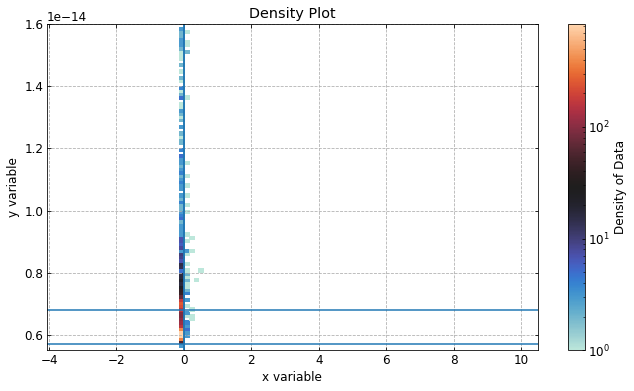

In [331]:
#checking the fit of our amplitudes v chi2
#a "good" fit against chi2 will be about ~ number of bins
fig, ax = dp.densityplot(
    df.ofamp_nodelay_CPDv21Ge*1e6,
    df.ofchi2_nodelay_CPDv21Ge,
    cut=crandoms,
    nbins = (100,100),
    ylims=[0.55e-14, 1.6e-14],
 #   xlims=[0, 1],
)


#check pulse shape for the split distribution rise and fall
ax.axvline(x=9e-7,ymin=0.6e-14,ymax=1)
ax.axvline(x=2e-7,ymin=0.8e-14,ymax=1)
ax.axhline(y=0.68e-14, xmin=0, xmax=1)
ax.axhline(y=0.57e-14, xmin=0, xmax=1)


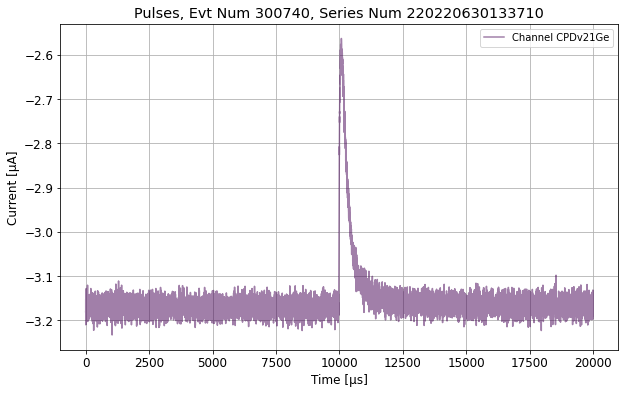

In [225]:
check_cut_lower = (dp.inrange(df.ofamp_unconstrained_CPDv21Ge, 0.2e-7, 1.2e-7)
                   & 
                   dp.inrange(df.ofchi2_unconstrained_CPDv21Ge, 0.58e-14, 0.635e-14)
                  )
#create a new template for the upper cut, pull traces
check_cut_upper = (dp.inrange(df.ofamp_unconstrained_CPDv21Ge, 2e-7, 9e-7)
                   & 
                   dp.inrange(df.ofchi2_unconstrained_CPDv21Ge, 0.68e-14, 1.4e-14)
                  )

'''lower_rands = getrandevents(trigger_path,
    df.eventnumber,
    df.seriesnumber,
    ntraces=20,
    nplot=1,
    channels=['CPDv21Ge'],
    cut=ctrigger & check_cut_lower & ctime,
    lgcplot=True)
    ''';
upper_rands = getrandevents(trigger_path,
    df.eventnumber,
    df.seriesnumber,
    ntraces=100,
    nplot=1,
    channels=['CPDv21Ge'],
    cut=ctrigger & check_cut_upper & ctime,
    lgcplot=True)

(9500.0, 12500.0)

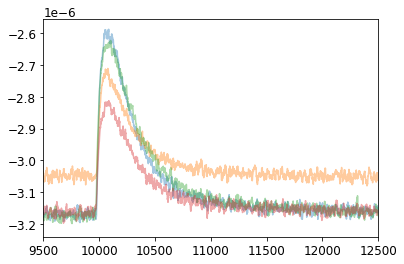

In [232]:

#plt.xlim(9500, 11000)
#dp.scatter(t, lowpassed_upper)
#np.ndim(x)
#upper_rands
t = upper_rands[0]
x = upper_rands[1]
cout_upper = upper_rands[2]
lowpassed_upper = qp.utils.lowpassfilter(x)

t1 = lower_rands[0]
x1 = lower_rands[1]
cout_lower = lower_rands[2]
lowpassed_lower = qp.utils.lowpassfilter(x1)


#for xx in lowpassed_lower[:4,0], lowpassed_upper[:4,0]:
 #   plt.plot(t1*1e6, xx, alpha=0.4)
    

for xx in lowpassed_upper[:4,0]:
    plt.plot(t*1e6, xx, alpha=0.4)
# plt.plot(t1*1e6, lowpassed_lower[5,0])
plt.xlim(9500, 12500)

In [227]:
#for xx in lowpassed_lower[:4,0]:
#    plt.plot(t1*1e6, xx, alpha=0.4)

In [197]:
#df.ofamp_nodelay_CPDv21Ge[check_cut_lower]
#df.triggeramp[check_cut_lower]

## OF Amplitude

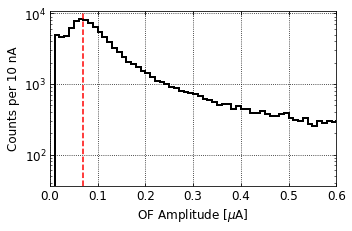

In [153]:
fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/8))
_, ax = dp.hist(
    df.ofamp_unconstrained_CPDv21Ge[ctrigger & cbaseline & ctime] * 1e6,
    xlims=(0, 1),
    ax=ax,
    nbins=100,
    cmap='binary_r',
)
ax.set_title('')
ax.get_legend().remove()
ax.set_ylabel(r'Counts per 10 nA')
ax.set_xlabel(r'OF Amplitude [$\mu$A]')
ax.set_xlim(0, 0.6)
# ax.set_ylim(0.1, 1e3)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')

ax.axvline(0.07, color='r', linestyle='dashed')


fig.tight_layout()

In [164]:
qp.OptimumFilter(template, template, psd, fs).energy_resolution() * 24e3 / 0.07e-6
#what to set these numbers to ? 

1202810762618.4346

## Energy Scale

In [176]:
'''df['integral_baseline_sub_CPDv21Ge'] = df.integral_CPDv21Ge - df.baseline_CPDv21Ge * 2000 / fs
df.energyabsorbed_CPDv21Ge()
rsh = 5e-3
i0 = -11.132e-6
rpar = 4.4e-3
ev_constants = 11e-14
settings = h5_reader.get_detector_config(
    '/sdata2/runs/run18/raw/continuous_I2_D20220624_T153142/cont_I2_D20220624_T153143_F0001.hdf5',
)

conv_int_to_eV = -(float(settings['CPDv21Ge']['tes_bias']) * rsh - 2 * i0 * (rsh + rpar)) / ev_constants
df['energy_integral_CPDV2Ge'] = df.integral_baseline_sub_CPDv21Ge * conv_int_to_eV

#the divisor is not correct and is just a place holder
''';

(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Histogram'}, xlabel='variable', ylabel='Count'>)

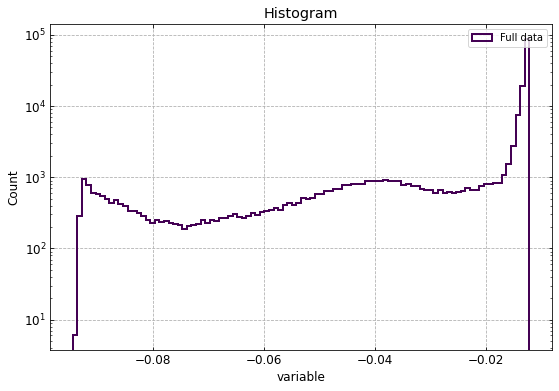

In [175]:
dp.hist(
    df.energy_integral_CPDV2Ge[ctrigger&ctime&cbaseline],
    nbins=100,
)

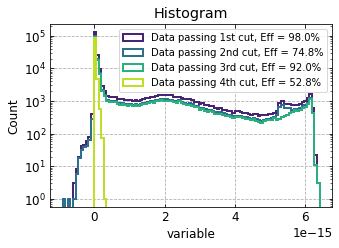

In [191]:

ctemp = dp.inrange(df.ofamp_constrained_CPDv21Ge, 0.1e-7, 0.2e-7)

fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/8))
_, ax = dp.hist(
   - df.energyabsorbed_CPDv21Ge,
 #   xlims=(0, 2),
    ax=ax,
    nbins=100,
#     cmap='binary_r',
    cuts=[ctrigger, ctime, cbaseline, cchi2],
    lgcrawdata=False,
)

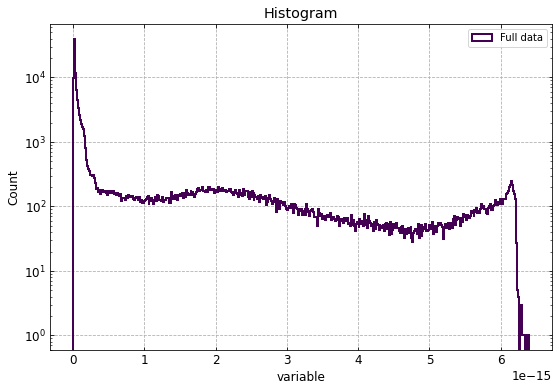

In [186]:
fig, ax = dp.hist(
    -df.energyabsorbed_CPDv21Ge[cbaseline&ctrigger&ctime],
    nbins=500,
   # xlims=(0,2e-16)
    )

In [70]:
tot_runtime = df.eventtime[ctrigger].iloc[-1]-df.eventtime[ctrigger].iloc[0]
#rate of the events at pulse in Hz
sum(check_cut_lower)/tot_runtime


3.0977573378962235

In [132]:
tot_runtime = df.eventtime[ctrigger].iloc[-1]-df.eventtime[ctrigger].iloc[0]
#rate of the events at pulse in Hz
sum(check_cut_upper)/tot_runtime


2.3141969016274793

## Getting Baseline Energy Res

In [313]:
tracelength=20e-3
#not sure why 30
chi_thresh= int(tracelength*fs) + 30 * np.sqrt(2 * int(tracelength*fs))
chi_thresh_lower= int(tracelength*fs) - (30 * np.sqrt(2 * int(tracelength*fs)))
crandschisqared = (((df.ofchi2_nodelay_CPDv21Ge < chi_thresh) 
                    & (df.ofchi2_nodelay_CPDv21Ge > chi_thresh_lower))
)
crandschisqared

crandschi = (df.ofchi2_unconstrained_CPDv21Ge < 0.635e-14)&(df.ofchi2_unconstrained_CPDv21Ge > 0.2e-14)


In [314]:
df.ofamp_nodelay_CPDv21Ge[crandoms&crandschi]

0     -1.614736e-10
2      2.727784e-10
4     -6.286993e-10
7      4.269496e-10
8     -3.319478e-10
           ...     
991   -3.283641e-10
993    2.390390e-09
994   -6.738697e-10
998   -2.422444e-09
999    2.919924e-10
Name: ofamp_nodelay_CPDv21Ge, Length: 3015, dtype: float64

(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Randomly Triggered Event Distribution'}, xlabel='Calibrated OF Amplitude (no delay) (keV)', ylabel='Counts'>)

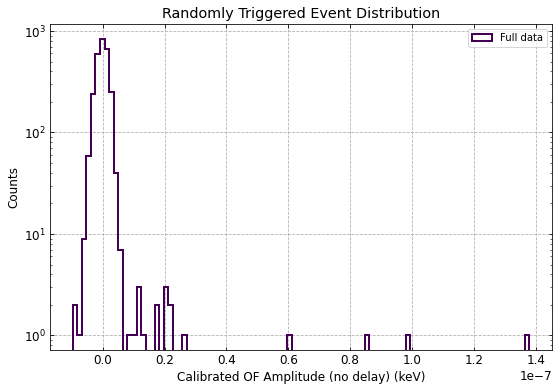

In [321]:
dp.hist(
    df.ofamp_nodelay_CPDv21Ge[crandoms&cchi2&ctime],
    nbins=100,
    #xlims=(-0.1,0.1),
    labeldict = {'title' : 'Randomly Triggered Event Distribution',
                'xlabel' : 'Calibrated OF Amplitude (no delay) (keV)',
                'ylabel' : 'Counts',
                },
)

In [240]:
#fitting for the upper band
#returns amplitude or pulse height, rise time, fall time, time offset 
#new template, average a bunch of rise and fall times from fitting to pass to new template
call_fall = []

for i in range(0,2):
    call_fall.append(NLIN.fit_falltimes(x[i, 0], npolefit=2, 
                                    guess=(0.04e-6, 10e-6, 60e-6, 10e-3), lgcplot=False)
                )
    #print(call_fall[0:])
    

[array([5.73424369e-07, 3.77093102e-05, 2.91445621e-04, 9.97809601e-03])]
[array([5.73424369e-07, 3.77093102e-05, 2.91445621e-04, 9.97809601e-03]), array([3.20172904e-07, 3.54158025e-05, 2.63602042e-04, 9.98118913e-03])]


In [266]:
#for index, row in call_fall:
#    print(
#        f"{row[0] * 1e6:.1f}",
#    )
np.shape(call_fall)
call_fall[0:][0:1]

[array([5.73424369e-07, 3.77093102e-05, 2.91445621e-04, 9.97809601e-03])]

array([1.02072882e-07, 9.89283505e-06, 1.95316180e-04, 1.00064164e-02])

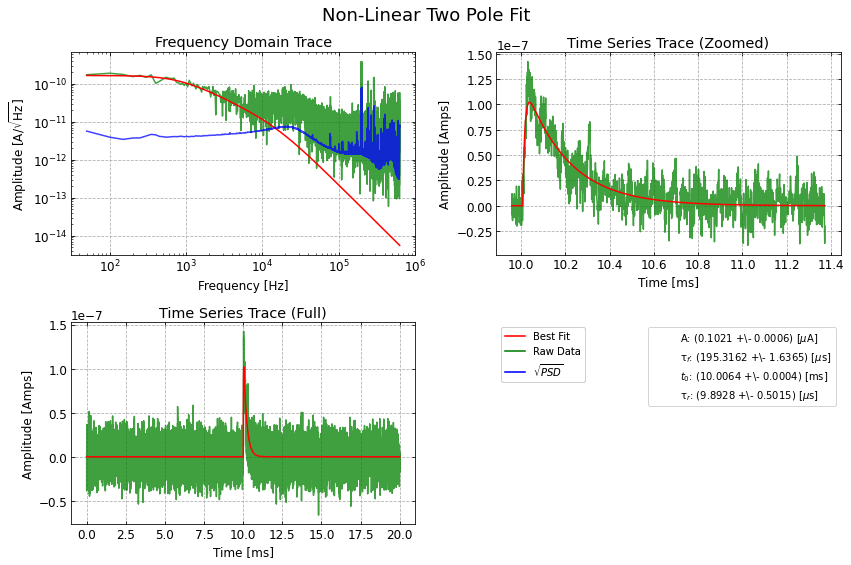

In [86]:
with open(yaml_path) as f:
    yaml_dict = yaml.load(f)

NLIN = (qp.OFnonlin(np.loadtxt
                (yaml_dict['CPDv21Ge']
                ['psd_path']) * 1e-20, 1.25e6)
       )
#returns amplitude or pulse height, rise time, fall time, time offset 
NLIN.fit_falltimes(x1[10, 0], npolefit=2, guess=(0.04e-6, 10e-6, 60e-6, 10e-3), lgcplot=True)

(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Histogram'}, xlabel='variable', ylabel='Count'>)

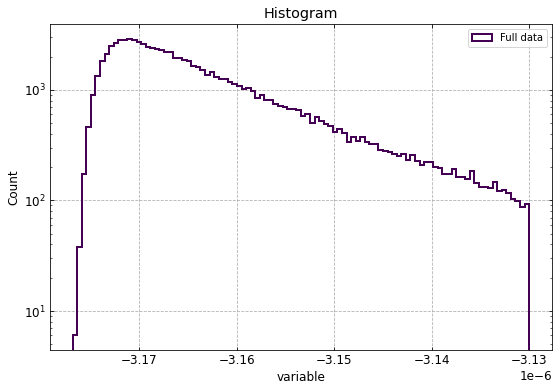

In [63]:
#checking the baseline distribution
dp.hist(
    df.baseline_CPDv21Ge[cmask],
    nbins=100,
)

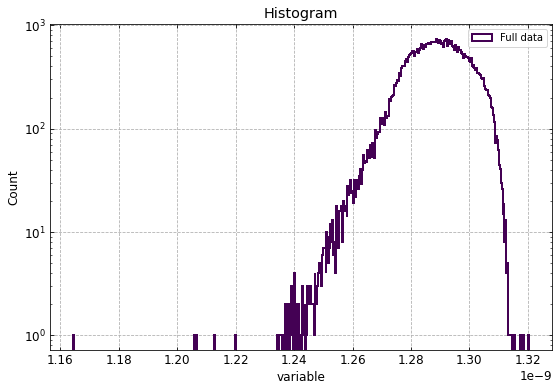

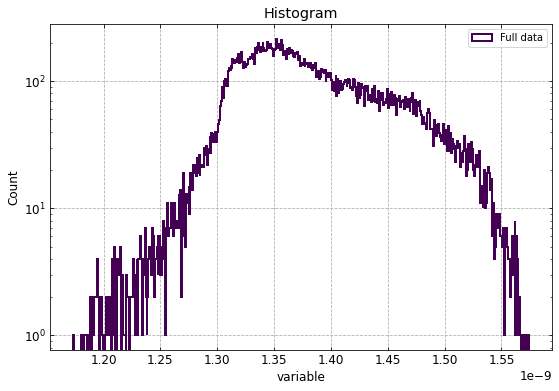

In [147]:
#integral of an event without baseline subtraction
#remove the baseline to avoid including an elevated or negative baseline
#make sure baseline is scaled the same as pulse integral
fig, ax = dp.hist(
    df.integral_CPDv21Ge[ctrigger&ctime&check_cut_lower] - df.baseline_CPDv21Ge[ctrigger&ctime&check_cut_lower] * (2000/1.25e6),
    nbins=500,
    #xlims=
)
fig, ax = dp.hist(
    df.integral_CPDv21Ge[ctrigger&ctime&check_cut_upper] - df.baseline_CPDv21Ge[ctrigger&ctime&check_cut_upper] * (2000/1.25e6),
    nbins=500,
    #xlims=
)

#fig.savefig("/home/hadley_santana/Downloads/integral_gaas.png", dpi=500)

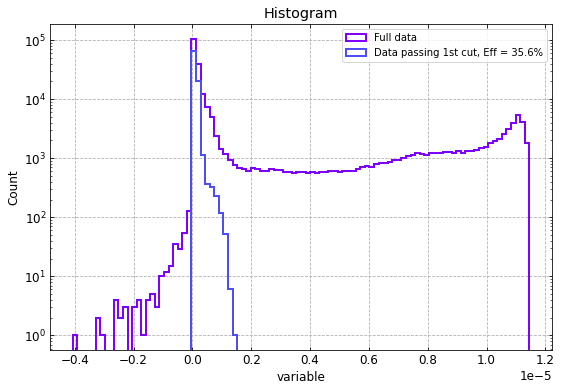

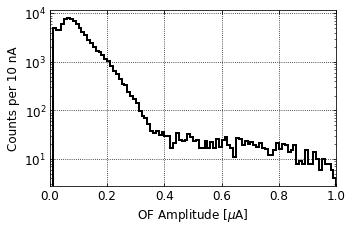

In [121]:
#check the distribution of amplitudes
fig, ax = dp.hist(
    df.ofamp_nodelay_CPDv21Ge,
    cuts=[cmask],
    nbins=100,
    cmap='rainbow'
    #xlims=
)
fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/8))
_, ax = dp.hist(
    df.ofamp_unconstrained_CPDv21Ge[cmask] * 1e6,
    xlims=(0, 1),
    ax=ax,
    nbins=100,
    cmap='binary_r',
)
ax.set_title('')
ax.get_legend().remove()
ax.set_ylabel(r'Counts per 10 nA')
ax.set_xlabel(r'OF Amplitude [$\mu$A]')
ax.set_xlim(0, 1)
# ax.set_ylim(0.8, 1e3)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
fig.tight_layout()

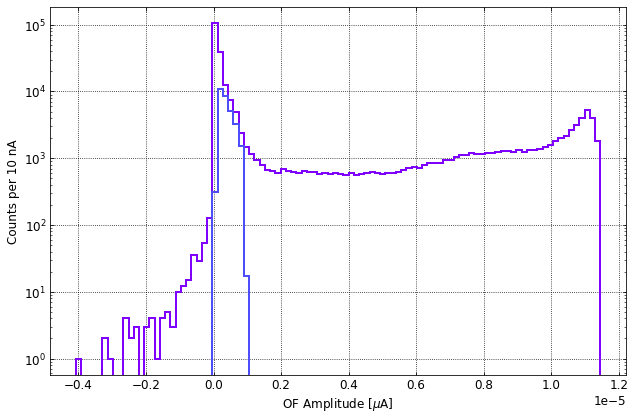

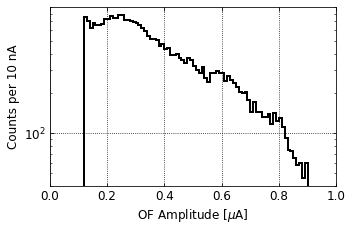

In [141]:
fig, ax = dp.hist(
    df.ofamp_nodelay_CPDv21Ge,
    cuts=[ctrigger&ctime&check_cut_upper],
    nbins=100,
    cmap='rainbow'
    #xlims=
)
ax.set_title('')
ax.get_legend().remove()
ax.set_ylabel(r'Counts per 10 nA')
ax.set_xlabel(r'OF Amplitude [$\mu$A]')
#ax.set_xlim(0, 1)
# ax.set_ylim(0.8, 1e3)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
fig.tight_layout()
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_18/uppereff_ofamp_6sigma_I2_D20220628_T132125',
    dpi=500,
    facecolor='none',
)
fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/8))
_, ax = dp.hist(
    df.ofamp_unconstrained_CPDv21Ge[ctrigger&ctime&check_cut_upper] * 1e6,
    xlims=(0, 1),
    ax=ax,
    nbins=100,
    cmap='binary_r',
)
#fig.savefig(
 #   '/data/users/da_real_maggie_reed/analysis/run_18/uppereff_ofamp_6sigma_I2_D20220628_T132125',
  #  dpi=500,
   # facecolor='none',
#)
ax.set_title('')
ax.get_legend().remove()
ax.set_ylabel(r'Counts per 10 nA')
ax.set_xlabel(r'OF Amplitude [$\mu$A]')
ax.set_xlim(0, 1)
# ax.set_ylim(0.8, 1e3)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
fig.tight_layout()

fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_18/upper_ofamp_6sigma_I2_D20220628_T132125',
    dpi=500,
    facecolor='none',
)